In [1]:
from rich import print
from rich import pretty
pretty.install()
from icecream import ic
from rich.console import Console
console = Console()
from IPython.display import Markdown

import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from pathlib import Path
import pathlib
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import losses
from keras.callbacks import ModelCheckpoint # to save models
from keras.models import load_model # load model from disk
from scipy.stats import norm
from embed_sources import create_sentence_embedding
from sentence_transformers import SentenceTransformer

import time
from sklearn.neighbors import NearestNeighbors
np.random.seed(42)

from utils import *

import weaviate, json
from weaviate import EmbeddedOptions


2023-12-21 14:25:45.514922: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 14:25:45.514987: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 14:25:45.516209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 14:25:45.525965: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 14:25:46.786832: W tensorflow/comp

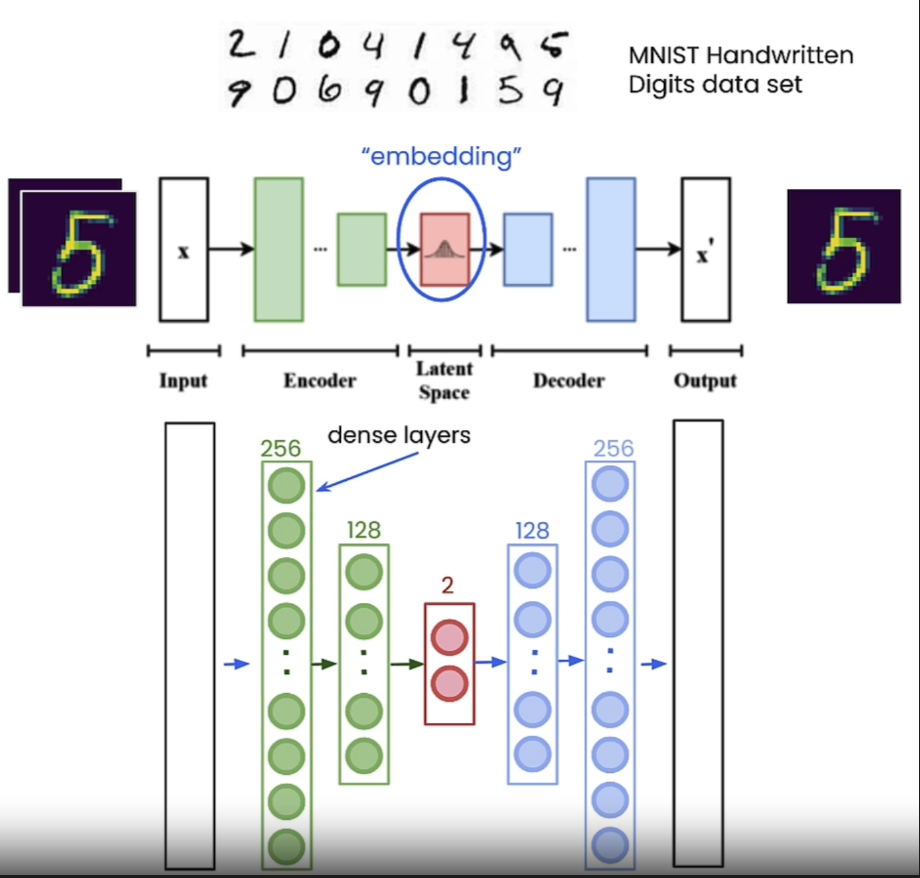{:width='500px'}

In [4]:
# Load data – training and test
(x_tr, y_tr), (x_te, y_te) = mnist.load_data()


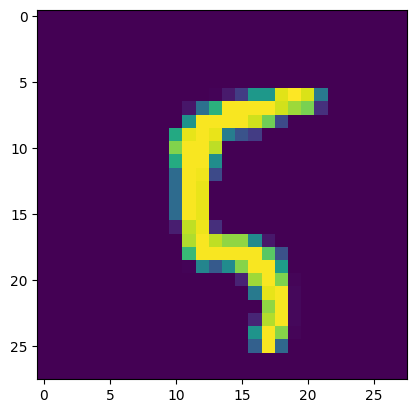

In [5]:
# lets view one of the images
plt.imshow(x_tr[100])


In [6]:
def print_shape(X_train = x_tr, y_train = y_tr, X_test = x_te, y_test = y_te):
    print(f"""
    The shape of X_train is {X_train.shape}\n
    The shape of y_train is {y_train.shape}\n
    The shape of X_test is {X_test.shape}\n
    The shape of y_test is {y_test.shape}\n
    """)
    return None


In [7]:
print_shape()


The shape of X_train is (60000, 28, 28)

    The shape of y_train is (60000,)

    The shape of X_test is (10000, 28, 28)

    The shape of y_test is (10000,)

In [8]:
# normalize the image pixel to between 0 - 255 and reshape the array to a 2-dimensional array
#Normalize and Reshape images (flatten)
x_tr, x_te = x_tr.astype('float32')/255., x_te.astype('float32')/255.
x_tr_flat, x_te_flat = x_tr.reshape(x_tr.shape[0], -1), x_te.reshape(x_te.shape[0], -1)

print_shape(x_tr_flat, y_tr, x_te_flat, y_te)


The shape of X_train is (60000, 784)

    The shape of y_train is (60000,)

    The shape of X_test is (10000, 784)

    The shape of y_test is (10000,)

In [9]:
# create a sampling function to be able to grab number of images randomly during training.
# sampling function
def sampling(args):
    mu, log_var = args
    eps = K.random_normal(shape=(batch_size, z_dim), mean=0., stddev=1.0)
    return mu + K.exp(log_var) * eps


In [10]:
# set the network parameters
# Neural Network Parameters
batch_size, n_epoch = 100, 50
n_hidden, z_dim = 256, 2


In [11]:
# Encoder - from 784->256->128->2
inputs_flat = Input(shape=(x_tr_flat.shape[1:]))
x_flat = Dense(n_hidden, activation='relu')(inputs_flat) # first hidden layer
x_flat = Dense(n_hidden//2, activation='relu')(x_flat)  # second hidden layer

# hidden state, which we will pass into the Model to get the Encoder.
mu_flat = Dense(z_dim)(x_flat)
log_var_flat = Dense(z_dim)(x_flat)
z_flat = Lambda(sampling, output_shape=(z_dim,))([mu_flat, log_var_flat])


In [12]:
#Decoder - from 2->128->256->784
latent_inputs = Input(shape=(z_dim,))
z_decoder1 = Dense(n_hidden//2, activation='relu')
z_decoder2 = Dense(n_hidden, activation='relu')
y_decoder = Dense(x_tr_flat.shape[1], activation='sigmoid')
z_decoded = z_decoder1(latent_inputs)
z_decoded = z_decoder2(z_decoded)
y_decoded = y_decoder(z_decoded)
decoder_flat = Model(latent_inputs, y_decoded, name="decoder_conv")

outputs_flat = decoder_flat(z_flat)


In [13]:
# variational autoencode (VAE) - to reconstruction input
reconstruction_loss = losses.binary_crossentropy(
    inputs_flat,
    outputs_flat) * x_tr_flat.shape[1]
kl_loss = 0.5 * K.sum(
    K.square(mu_flat) + K.exp(log_var_flat) - log_var_flat -1 , axis = -1)

vae_flat_loss = reconstruction_loss + kl_loss

# Build model
# ensure that the reconstructed ouputs are as close to the inputs as possible
vae_flat = Model(inputs_flat, outputs_flat)
vae_flat.add_loss(vae_flat_loss)
vae_flat.compile(optimizer = 'adam')


In [24]:
checkpoint_path = "./vae_checkpoint.h5"  # Path to save the model file
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min')

# train and save the model with minimum loss
vae_flat.fit(
    x_tr_flat,
    shuffle=True,
    epochs=n_epoch,
    batch_size=batch_size,
    validation_data=(x_te_flat, None),
    verbose=1,
    callbacks=[checkpoint]
)

# vae_flat.fit(
#     x_tr_flat,
#     shuffle=True,
#     epochs=n_epoch,
#     batch_size=batch_size,
#     validation_data=(x_te_flat, None),
#     verbose=1
# )


Epoch 1/50
600/600 [==============================] - 6s 9ms/step - loss: 195.3546 - val_loss: 169.7007
Epoch 2/50
 13/600 [..............................] - ETA: 5s - loss: 170.4766

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


600/600 [==============================] - 6s 9ms/step - loss: 166.6146 - val_loss: 162.1549
Epoch 3/50
600/600 [==============================] - 5s 9ms/step - loss: 160.3426 - val_loss: 157.5592
Epoch 4/50
600/600 [==============================] - 5s 9ms/step - loss: 155.6575 - val_loss: 153.4986
Epoch 5/50
600/600 [==============================] - 5s 9ms/step - loss: 152.5802 - val_loss: 151.0482
Epoch 6/50
600/600 [==============================] - 5s 9ms/step - loss: 150.4955 - val_loss: 149.6788
Epoch 7/50
600/600 [==============================] - 5s 9ms/step - loss: 148.9317 - val_loss: 148.4997
Epoch 8/50
600/600 [==============================] - 6s 10ms/step - loss: 147.7171 - val_loss: 147.3175
Epoch 9/50
600/600 [==============================] - 5s 9ms/step - loss: 146.4149 - val_loss: 146.3131
Epoch 10/50
600/600 [==============================] - 5s 9ms/step - loss: 145.5969 - val_loss: 145.7024
Epoch 11/50
600/600 [==============================] - 5s 9ms/step - loss

<keras.src.callbacks.History object at 0x7f4e1cc7cb20>

In [25]:
# load saved model from disk
saved_vae = load_model("./vae_checkpoint.h5")


In [14]:

# Build encoders
encoder_f = Model(inputs_flat, z_flat)  # flat encoder
# encoder_f.save("flat_encoder_model.h5")
encoder_f_saved = load_model("flat_encoder_model.h5")


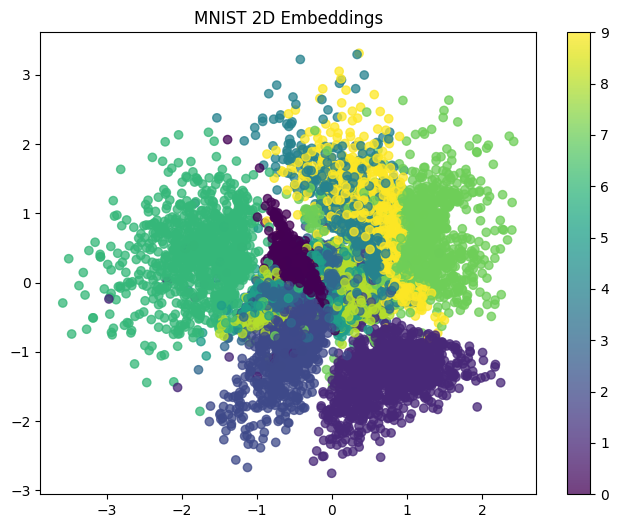

In [16]:
# Plot of the digit classes in the latent space
x_te_latent = encoder_f_saved.predict(x_te_flat, batch_size=batch_size,verbose=0)
plt.figure(figsize=(8, 6))
plt.scatter(x_te_latent[:, 0], x_te_latent[:, 1], c=y_te, alpha=0.75)
plt.title('MNIST 2D Embeddings')
plt.colorbar()
plt.show()


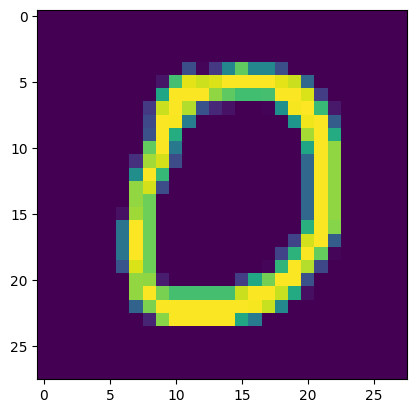

In [47]:
# let us now compare vector embedding
plt.imshow(x_te_flat[10].reshape(28, 28))


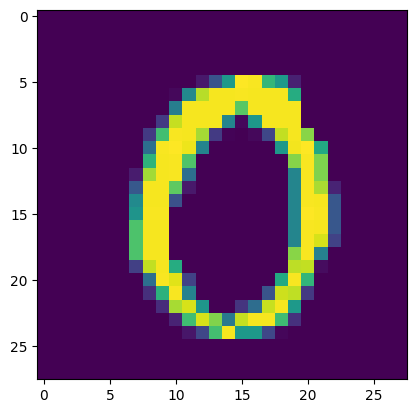

In [48]:
plt.imshow(x_te_flat[13].reshape(28,28));


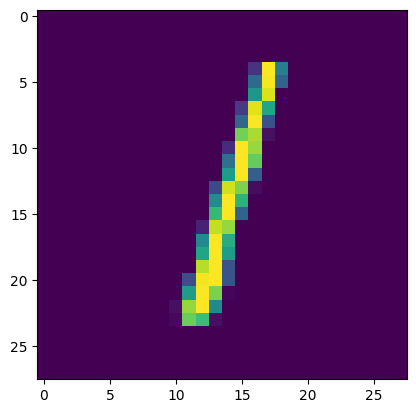

In [49]:
plt.imshow(x_te_flat[2].reshape(28,28));


In [58]:
# lookup vectors for each digits
zero_A = x_te_latent[10]
zero_B = x_te_latent[13]
one = x_te_latent[2]

print(f"Embedding for the first ZERO is  {zero_A}")
print(f"Embedding for the second ZERO is {zero_B}")
print(f"Embedding for the ONE is         {one}")


Embedding for the first ZERO is  [-0.6122462  0.2116596]

Embedding for the second ZERO is [-0.61816514  0.10302016]

Embedding for the ONE is         [ 0.7550135 -1.7870318]

In [ ]:
#Sentences we want to encode. Example:
sentence = ['The team enjoyed the hike through the meadow',
            'The national park had great views',
            'Olive oil drizzled over pizza tastes delicious']
model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
# model = SentenceTransformer("all-mpnet-base-v2")

# get the embedding of the query
sentence_embedding, _ = create_sentence_embedding(sentence, model, bert = False)


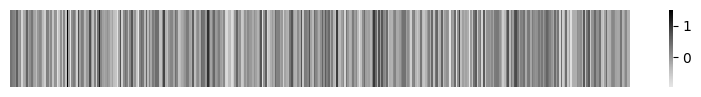

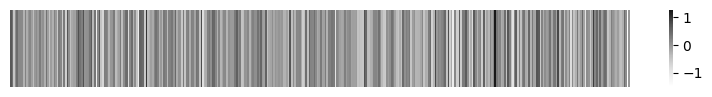

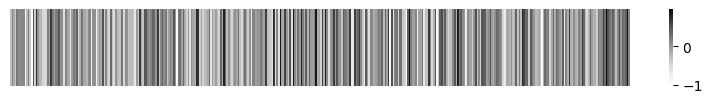

In [54]:
import seaborn as sns

sns.heatmap(sentence_embedding[0].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(sentence_embedding[1].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()

sns.heatmap(sentence_embedding[2].reshape(-1,384),cmap="Greys",center=0,square=False)
plt.gcf().set_size_inches(10,1)
plt.axis('off')
plt.show()


## How can we measure the distance between these Image and Sentence Embeddings?

There are many ways to calculate the distances between two vectors.

Here we will cover 4 distance metrics that you might find being used in the context of vector databases:
- Euclidean Distance(L2)
- Manhattan Distance(L1)
- Dot Product
- Cosine Distance

### Euclidean Distance(L2)
The length of the shortest path between two points or vectors.
![image.png](attachment:image.png)

In [64]:
# Euclidean Distance
L2 = [(zero_A[i] - zero_B[i])**2 for i in range(len(zero_A))]
L2 = np.sqrt(np.array(L2).sum())
print(L2)


0.10880055252586567

In [59]:
L2_np = np.linalg.norm((zero_A - zero_B), ord=2)
print(L2_np)


0.10880055

In [61]:
#Calculate L2 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=2))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=2))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=2))


Distance zeroA-zeroB: 0.10880055

Distance zeroA-one:   2.4216042

Distance zeroB-one:   2.3362184

# Manhatatan Distance (L1)
Distance between two points if one was constrained to move only along one axis at a time.

In [65]:
# Manhattan Distance
L1 = [zero_A[i] - zero_B[i] for i in range(len(zero_A))]
L1 = np.abs(L1).sum()

print(L1)


0.114558354

In [66]:
#an alternative way of doing this is
np.linalg.norm((zero_A - zero_B), ord=1)


0.114558354

In [67]:
#Calculate L1 distances
print("Distance zeroA-zeroB:", np.linalg.norm((zero_A - zero_B), ord=1))
print("Distance zeroA-one:  ", np.linalg.norm((zero_A - one), ord=1))
print("Distance zeroB-one:  ", np.linalg.norm((zero_B - one), ord=1))


Distance zeroA-zeroB: 0.114558354

Distance zeroA-one:   3.365951

Distance zeroB-one:   3.2632308

### Dot Product
Measures the magnitude of the projection of one vector onto the other.

In [68]:
# Dot Product
np.dot(zero_A,zero_B)


0.40027446

In [69]:
#Calculate Dot products
print("Distance zeroA-zeroB:", np.dot(zero_A, zero_B))
print("Distance zeroA-one:  ", np.dot(zero_A, one))
print("Distance zeroB-one:  ", np.dot(zero_B, one))


Distance zeroA-zeroB: 0.40027446

Distance zeroA-one:   -0.8404966

Distance zeroB-one:   -0.65082335

### Cosine Distance
Measure the difference in directionality between vectors.

In [70]:
# Cosine Distance
cosine = 1 - np.dot(zero_A,zero_B)/(np.linalg.norm(zero_A)*np.linalg.norm(zero_B))
print(f"{cosine:.6f}")


0.014031

In [71]:
zero_A / zero_B


array([0.990425 , 2.0545454], dtype=float32)

In [72]:
# Cosine Distance function
def cosine_distance(vec1,vec2):
  cosine = 1 - (np.dot(vec1, vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2)))
  return cosine

#Cosine Distance
print(f"Distance zeroA-zeroB: {cosine_distance(zero_A, zero_B): .6f}")
print(f"Distance zeroA-one:   {cosine_distance(zero_A, one): .6f}")
print(f"Distance zeroB-one:   {cosine_distance(zero_B, one): .6f}")


Distance zeroA-zeroB:  0.014031

Distance zeroA-one:    1.668801

Distance zeroB-one:    1.535318

## Now with the sentence embeddings!

Dot Product and Cosine Distance are commonly used in the field of NLP, to evaluate how similar two sentence embeddings are.
So here we will only use those two.

- embedding0 - 'The team enjoyed the hike through the meadow'

- embedding1 - The national park had great views'

- embedding2 - 'Olive oil drizzled over pizza tastes delicious'

In [74]:
#Dot Product
print("Distance 0-1:", np.dot(sentence_embedding[0], sentence_embedding[1]))
print("Distance 0-2:", np.dot(sentence_embedding[0], sentence_embedding[2]))
print("Distance 1-2:", np.dot(sentence_embedding[1], sentence_embedding[2]))


Distance 0-1: 26.497883

Distance 0-2: 2.0785782

Distance 1-2: 4.0192127

In [75]:
#Cosine Distance
print("Distance 0-1: ", cosine_distance(sentence_embedding[0], sentence_embedding[1]))
print("Distance 0-2: ", cosine_distance(sentence_embedding[0], sentence_embedding[2]))
print("Distance 1-2: ", cosine_distance(sentence_embedding[1], sentence_embedding[2]))


Distance 0-1:  0.535033643245697

Distance 0-2:  0.9639393091201782

Distance 1-2:  0.9288790747523308

# Searching for Similar Vectors

In [77]:
# Generate 20 data points with 2 dimenisions
X = np.random.rand(20, 2)
X.shape


(20, 2)

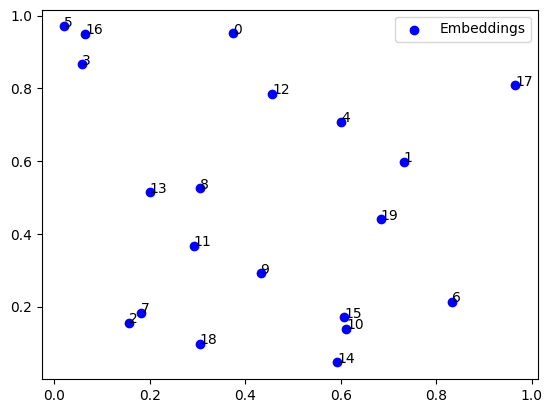

In [78]:
# Display Embeddings
n = range(len(X))
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1], color='blue', label="Embeddings")
ax.legend()

for i, txt in enumerate(n):
    ax.annotate(txt, (X[i, 0], X[i, 1]))


In [80]:
k = 4
neigh = NearestNeighbors(n_neighbors=k,
                         algorithm='brute',
                         metric="euclidean")
neigh.fit(X)


NearestNeighbors(algorithm='brute', metric='euclidean', n_neighbors=4)

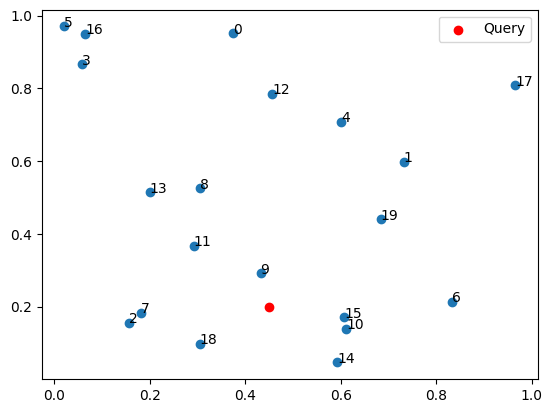

In [81]:
# Display Query with data
n = range(len(X))

fig, ax = plt.subplots()
ax.scatter(X[:,0], X[:,1])
ax.scatter(0.45,0.2, c='red',label='Query') # Our query vector
ax.legend()

for i, txt in enumerate(n):
    ax.annotate(txt, (X[i,0], X[i,1]))


In [82]:
neighbours = neigh.kneighbors([[0.45,0.2]], k, return_distance=True)
print(neighbours)


(array([[0.09299859, 0.16027853, 0.1727928 , 0.17778682]]), array([[ 9, 15, 10, 18]]))

In [83]:
from time import perf_counter

start = perf_counter()
neighbours = neigh.kneighbors([[0.45,0.2]], k, return_distance=True)
end = perf_counter()
print(f"Time taken to find {k} nearest neighbours: {end - start:.4f} seconds")


Time taken to find 4 nearest neighbours: 0.0079 seconds

In [87]:
def speed_test(count: int) -> float:
    # generate random objects
    data = np.random.rand(count,2)

    # prepare brute force index
    k=4
    neigh = NearestNeighbors(n_neighbors=k, algorithm='brute', metric='euclidean')
    neigh.fit(data)

    # measure time for a brute force query
    start = perf_counter()
    neighbours = neigh.kneighbors([[0.45,0.2]], k, return_distance=True)
    end = perf_counter()


    total_time = end - start
    print (f"Runtime: {total_time: .4f}")

    return total_time


In [88]:
speed_test(20)


Runtime:  0.0009

0.0009122820001721266

In [89]:
speed_test(50000)


Runtime:  0.0013

0.0013324789997568587

In [90]:
# Brute force examples
time200k = speed_test(200_000)
time2m = speed_test(2_000_000)
time20m = speed_test(20_000_000)
time200m = speed_test(200_000_000)


Runtime:  0.0028

Runtime:  0.0208

Runtime:  0.2837

Runtime:  3.4004

In [103]:
# let us test this on higher dimension embeddings
documents = 1000
dimensions = 768
embeddings = np.random.randn(documents, dimensions) # 1000 documents, 768-dimensional embeddings
embeddings = embeddings / np.sqrt((embeddings**2).sum(1, keepdims=True)) # L2 normalize the rows, as is common

query = np.random.randn(768) # the query vector
query = query / np.sqrt((query**2).sum()) # normalize query


In [107]:
# KNN
start = perf_counter()
# Calculate the dot product between the query vector and all the document vectors:
similarities = embeddings.dot(query)

# sort result
sorted_ix = np.argsort(similarities)[::-1]
# sorted_ix = np.argsort(-similarities)
end = perf_counter()
total_time = end - start

print(f"Runtime for dim={dimensions}, documents_n={documents}: {np.round(total_time,3)} seconds")

print("Top 5 results:")
for k in sorted_ix[:5]:
    print(f"Point: {k}, Similarity: {similarities[k]}")


Runtime for dim=768, documents_n=1000: 0.002 seconds

Top 5 results:

Point: 383, Similarity: 0.10886901220512361

Point: 958, Similarity: 0.10239422484498059

Point: 645, Similarity: 0.09903704093560162

Point: 197, Similarity: 0.09318231779975597

Point: 580, Similarity: 0.09085609162546429

In [115]:
n_runs = [1_000, 10_000, 100_000, 500_000]

for n in n_runs:
    embeddings = np.random.randn(n, dimensions) #768-dimensional embeddings
    query = np.random.randn(768) # the query vector

    start = perf_counter()
    similarities = embeddings.dot(query)
    sorted_ix = np.argsort(-similarities)
    end = perf_counter()
    total_time = end - start
    print(f"Runtime for 1 query with dim={dimensions}, documents_n={n}: {np.round(total_time,3)} seconds")


Runtime for 1 query with dim=768, documents_n=1000: 0.0 seconds

Runtime for 1 query with dim=768, documents_n=10000: 0.003 seconds

Runtime for 1 query with dim=768, documents_n=100000: 0.026 seconds

Runtime for 1 query with dim=768, documents_n=500000: 0.142 seconds

In [116]:
print (f"To run 1,000 queries: {total_time * 1_000/60 : .2f} minutes")


To run 1,000 queries:  2.36 minutes

# How to make the vector search more efficient using weaviate and ANN

In [17]:
# Remove old weaviate DB files
!rm -rf ~/.local/share/weaviate


In [18]:
vec_num = 40 # number of vectors (nodes)

# Dimension.  Set to be 2. All the graph plots are for dim 2. If changed, then plots should be commented.
dim = 2
m_nearest_neighbor = 2 # M Nearest Neigbor used in construction of the Navigable Small World (NSW)
vec_pos = np.random.uniform(size=(vec_num, dim))


In [21]:
# Query
query_vec = [0.5, 0.5]
nodes = []
nodes.append(("Q", {"pos": query_vec}))
G_query = nx.Graph()
G_query.add_nodes_from(nodes)
print("nodes = ", nodes, flush=True)
pos_query = nx.get_node_attributes(G_query, 'pos')


nodes = 
[('Q', {'pos': [0.5, 0.5]})]

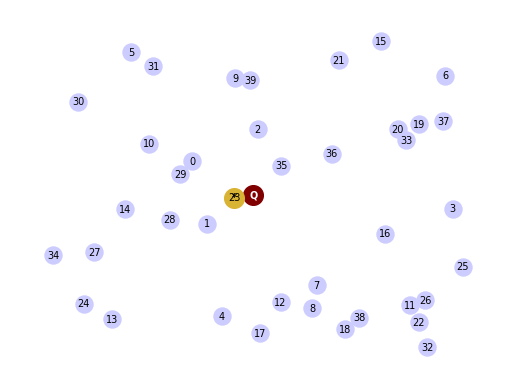

In [22]:
# Brute force algorithm to find the best possible vector embedding
(G_lin, G_best) = nearest_neigbor(vec_pos,query_vec)

pos_lin=nx.get_node_attributes(G_lin,'pos')
pos_best=nx.get_node_attributes(G_best,'pos')

fig, axs = plt.subplots()

nx.draw(G_lin, pos_lin, with_labels=True, node_size=150, node_color=[[0.8,0.8,1]], width=0.0, font_size=7, ax = axs)
nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.5,0,0]], font_color='white', width=0.5, font_size=7, font_weight='bold', ax = axs)
nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)


## HNSW Construction

layer_i =  3

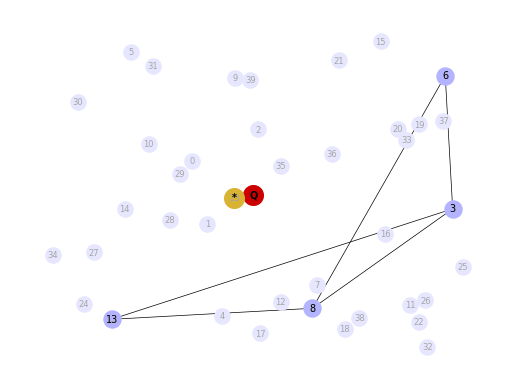

layer_i =  2

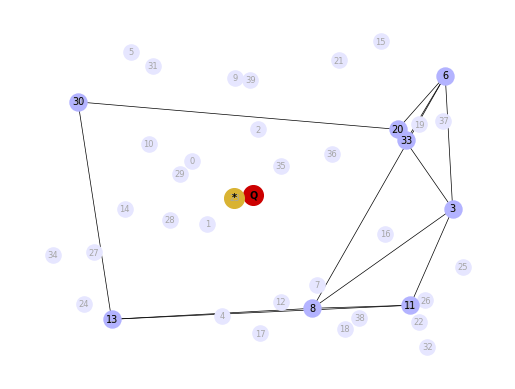

layer_i =  1

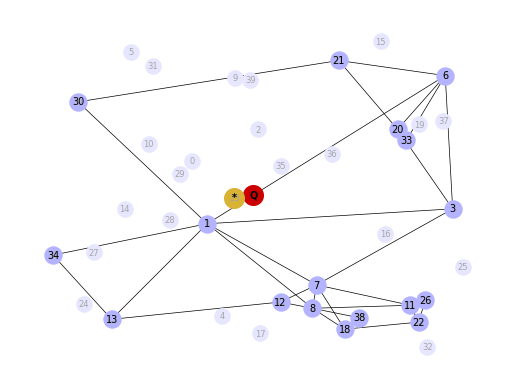

layer_i =  0

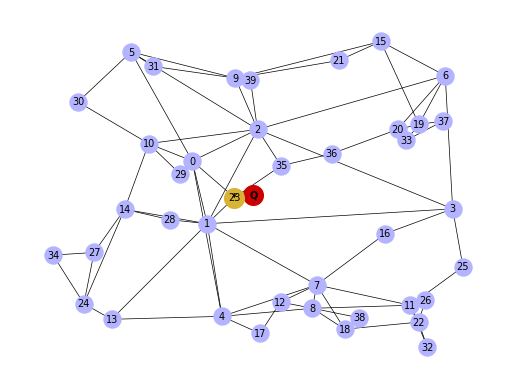

In [23]:
GraphArray = construct_HNSW(vec_pos,m_nearest_neighbor)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)

    if layer_i>0:
        pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
        nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=150, node_color=[[0.7,0.7,1]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=200, node_color=[[0.8,0,0]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=200, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, font_weight='bold', ax = axs)
    plt.show()


# HNSW Search

layer_i =  3

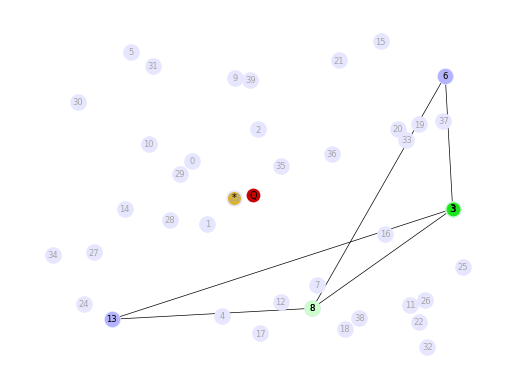

layer_i =  2

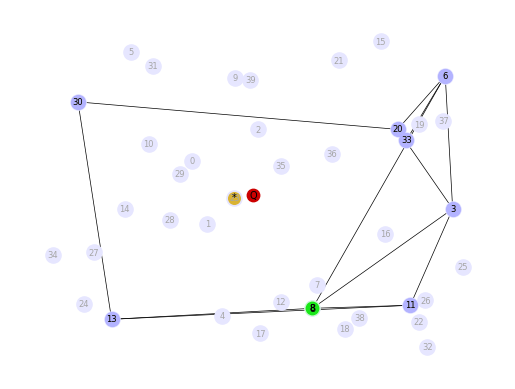

layer_i =  1

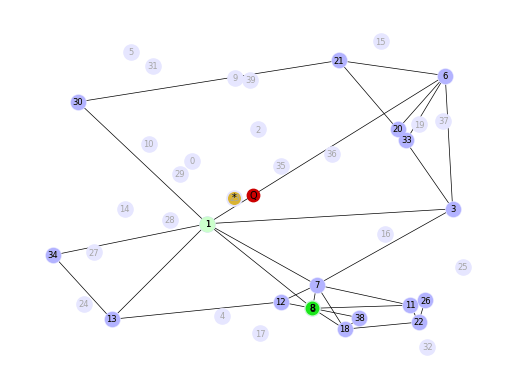

layer_i =  0

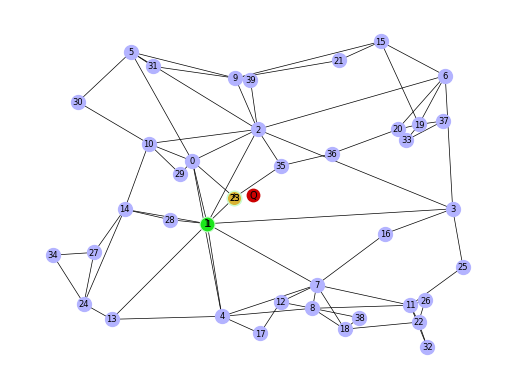

In [24]:
(SearchPathGraphArray, EntryGraphArray) = search_HNSW(GraphArray,G_query)

for layer_i in range(len(GraphArray)-1,-1,-1):
    fig, axs = plt.subplots()

    print("layer_i = ", layer_i)
    G_path_layer = SearchPathGraphArray[layer_i]
    pos_path = nx.get_node_attributes(G_path_layer,'pos')
    G_entry = EntryGraphArray[layer_i]
    pos_entry = nx.get_node_attributes(G_entry,'pos')

    if layer_i>0:
            pos_layer_0 = nx.get_node_attributes(GraphArray[0],'pos')
            nx.draw(GraphArray[0], pos_layer_0, with_labels=True, node_size=120, node_color=[[0.9,0.9,1]], width=0.0, font_size=6, font_color=(0.65,0.65,0.65), ax = axs)

    pos_layer_i = nx.get_node_attributes(GraphArray[layer_i],'pos')
    nx.draw(GraphArray[layer_i], pos_layer_i, with_labels=True, node_size=100, node_color=[[0.7,0.7,1]], width=0.5, font_size=6, ax = axs)
    nx.draw(G_path_layer, pos_path, with_labels=True, node_size=110, node_color=[[0.8,1,0.8]], width=0.5, font_size=6, ax = axs)
    nx.draw(G_query, pos_query, with_labels=True, node_size=80, node_color=[[0.8,0,0]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_best, pos_best, with_labels=True, node_size=70, node_color=[[0.85,0.7,0.2]], width=0.5, font_size=7, ax = axs)
    nx.draw(G_entry, pos_entry, with_labels=True, node_size=80, node_color=[[0.1,0.9,0.1]], width=0.5, font_size=7, ax = axs)
    plt.show()


# Weaviate

In [2]:
client = weaviate.Client(
    embedded_options = EmbeddedOptions(),
)
client.is_ready()


Started /home/zeus/.cache: process ID 36575


{"action":"startup","default_vectorizer_module":"none","level":"info","msg":"the default vectorizer modules is set to \"none\", as a result all new schema classes without an explicit vectorizer setting, will use this vectorizer","time":"2023-12-21T14:26:23Z"}
{"action":"startup","auto_schema_enabled":true,"level":"info","msg":"auto schema enabled setting is set to \"true\"","time":"2023-12-21T14:26:23Z"}
{"level":"warning","msg":"Multiple vector spaces are present, GraphQL Explore and REST API list objects endpoint module include params has been disabled as a result.","time":"2023-12-21T14:26:23Z"}
{"action":"grpc_startup","level":"info","msg":"grpc server listening at [::]:50060","time":"2023-12-21T14:26:23Z"}
{"action":"restapi_management","level":"info","msg":"Serving weaviate at http://127.0.0.1:8079","time":"2023-12-21T14:26:23Z"}


True

In [4]:
# resetting the schema. CAUTION: This will delete your collection
# if client.schema.exists("MyCollection"):
#     client.schema.delete_class("MyCollection")

schema = {
    "class": "MyCollection",
    "vectorizer": "none",
    "vectorIndexConfig": {
        "distance": "cosine" # let's use cosine distance
    },
}

client.schema.create_class(schema)

print("Successfully created the schema.")


{"action":"hnsw_vector_cache_prefill","count":1000,"index_id":"mycollection_jLzxI1xwRKCh","level":"info","limit":1000000000000,"msg":"prefilled vector cache","time":"2023-12-21T14:29:01Z","took":91368}


Successfully created the schema.

In [5]:
# importing data into the vector DB
data = [
   {
      "title": "First Object",
      "foo": 99,
      "vector": [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
   },
   {
      "title": "Second Object",
      "foo": 77,
      "vector": [0.2, 0.3, 0.4, 0.5, 0.6, 0.7]
   },
   {
      "title": "Third Object",
      "foo": 55,
      "vector": [0.3, 0.1, -0.1, -0.3, -0.5, -0.7]
   },
   {
      "title": "Fourth Object",
      "foo": 33,
      "vector": [0.4, 0.41, 0.42, 0.43, 0.44, 0.45]
   },
   {
      "title": "Fifth Object",
      "foo": 11,
      "vector": [0.5, 0.5, 0, 0, 0, 0]
   },
]
